# Topic Trends - Big Data

This code was created from Martha and Sean's emerging topic code. 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

from brokenaxes import brokenaxes

### Data Ingestion

In [2]:
# big data corpus

# set data types
cols = ['Unnamed: 0', 'Unnamed: 0.1', 'Duplicates', 'index', 'PROJECT_ID',
       'ABSTRACT', 'Is it related to Big-Data', 'Expert name', 'label',
       'PROJECT_TERMS', 'PROJECT_TITLE', 'DEPARTMENT', 'AGENCY', 'IC_CENTER',
       'PROJECT_NUMBER', 'PROJECT_START_DATE', 'PROJECT_END_DATE',
       'CONTACT_PI_PROJECT_LEADER', 'OTHER_PIS', 'CONGRESSIONAL_DISTRICT',
       'DUNS_NUMBER', 'ORGANIZATION_NAME', 'ORGANIZATION_CITY',
       'ORGANIZATION_STATE', 'ORGANIZATION_ZIP', 'ORGANIZATION_COUNTRY',
       'BUDGET_START_DATE', 'BUDGET_END_DATE', 'CFDA_CODE', 'FY',
       'FY_TOTAL_COST', 'FY_TOTAL_COST_SUB_PROJECTS', 'ORG_COUNT', 'PI_COUNT',
       'FY_TOTAL_COST_SUM', 'NUM_RECORDS', 'final_tokens']
dtypes = {col: 'str' for col in cols}
dtypes["FY_TOTAL_COST"] = 'float'
dtypes["FY_TOTAL_COST_SUB_PROJECTS"] = 'float'
dtypes["ORG_COUNT"] = 'float'
dtypes["PI_COUNT"] = 'float'
dtypes["FY_TOTAL_COST_SUM"] = 'float'
dtypes["NUM_RECORDS"] = 'float'

df = pd.read_csv("../../../data/prd/Digital_abstract_labelled/tfidf_refined.csv", dtype = dtypes, engine = 'python')
df.reset_index(inplace=True, drop = True)

In [3]:
df.shape

(257123, 37)

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,1204,NaN,NaN,1204,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,NaN,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1.0,1.0,1519821.0,1.0,center molecular interfacing cmi enable integr...
1,1205,NaN,NaN,1205,90002,DRU: Integrated optimization of evacuation and...,NaN,NaN,NaN,Accounting; Address; Affect; American; Area; b...,DRU: INTEGRATED OPTIMIZATION OF EVACUATION AND...,NSF,NSF,NaN,0826832,9/1/2008,8/31/2012,"DAVIDSON, RACHEL A","NOZICK, LINDA; WACHTENDORF, TRICIA",00,059007500,UNIVERSITY OF DELAWARE,NEWARK,DE,19716-2553,UNITED STATES,NaN,NaN,47.075,2008,757499.0,NaN,1.0,1.0,757499.0,1.0,dru integrated optimization evacuation_shelter...
2,1211,NaN,NaN,1211,89992,ABSTRACT: The United States over the past two ...,NaN,NaN,NaN,Address; Award; Biomedical Research; Biotechno...,MOD AND DAT: PATENT POOLS AND BIOMEDICAL INNOV...,NSF,NSF,NaN,0830288,10/1/2008,9/30/2011,"LERNER, JOSH","TIROLE, JEAN",08,054552435,NATIONAL BUREAU OF ECONOMIC RESEARCH,CAMBRIDGE,MA,02138-5317,UNITED STATES,NaN,NaN,47.075,2008,400000.0,NaN,1.0,1.0,400000.0,1.0,united_states past decade see explosion patent...
3,1212,NaN,NaN,1212,90011,The Ohio State University College of Education...,NaN,NaN,NaN,career; career development; Collaborations; Co...,MATH AND SCIENCE MIDDLE SCHOOL PATHWAYS PORTAL...,NSF,NSF,NaN,0840824,9/1/2008,8/31/2011,"LIGHTLE, KIMBERLY S","KAHLE, JANE; HENTON, MARY; NAIR-PILLAI, SARITA",15,071650709,OHIO STATE UNIVERSITY RESEARCH FOUNDATION,COLUMBUS,OH,43210-1016,UNITED STATES,NaN,NaN,47.076,2008,2369022.0,NaN,1.0,1.0,2369022.0,1.0,ohio state university college education osu na...
4,1214,NaN,NaN,1214,90013,This multidisciplinary project draws upon soci...,NaN,NaN,NaN,career; Collaborations; Communities; Complex; ...,CDI-TYPE II: WHAT DRIVES THE DYNAMIC CREATION ...,NSF,NSF,NaN,0835614,9/15/2008,8/31/2012,"MCFARLAND, DANIEL","JURAFSKY, DANIEL; MANNING, CHRISTOPHER; POWELL...",14,009214214,STANFORD UNIVERSITY,STANFORD,CA,94305-6203,UNITED STATES,NaN,NaN,47.076,2008,1186174.0,NaN,1.0,1.0,1186174.0,1.0,multidisciplinary project draw sociology compu...


In [5]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Duplicates', 'index', 'PROJECT_ID',
       'ABSTRACT', 'Is it related to Big-Data', 'Expert name', 'label',
       'PROJECT_TERMS', 'PROJECT_TITLE', 'DEPARTMENT', 'AGENCY', 'IC_CENTER',
       'PROJECT_NUMBER', 'PROJECT_START_DATE', 'PROJECT_END_DATE',
       'CONTACT_PI_PROJECT_LEADER', 'OTHER_PIS', 'CONGRESSIONAL_DISTRICT',
       'DUNS_NUMBER', 'ORGANIZATION_NAME', 'ORGANIZATION_CITY',
       'ORGANIZATION_STATE', 'ORGANIZATION_ZIP', 'ORGANIZATION_COUNTRY',
       'BUDGET_START_DATE', 'BUDGET_END_DATE', 'CFDA_CODE', 'FY',
       'FY_TOTAL_COST', 'FY_TOTAL_COST_SUB_PROJECTS', 'ORG_COUNT', 'PI_COUNT',
       'FY_TOTAL_COST_SUM', 'NUM_RECORDS', 'final_tokens'],
      dtype='object')

In [6]:
# input needed for NMF (from Scikit-Learn) is one string per document (not a list of strings)

text = df["final_tokens"]

In [7]:
cb_pal = {"blue":'#377eb8', "orange":'#ff7f00', "green":'#4daf4a', "pink":'#f781bf', "brown":'#a65628', 
          "purple":'#984ea3', "gray":'#999999', "red":'#e41a1c', "yellow":'#dede00'}

### Functions needed for all models

In [8]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [9]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF

In [10]:
stop_wds = ['research', 'aim', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)

In [93]:
# create model

num_topics = 10

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 167.5044937133789


In [94]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('core', 3.518943632082329)
('center', 2.2474421873052273)
('clinical', 2.014250540670573)
('investigator', 1.8900113604325597)
('support', 1.836050876275694)
('program', 1.7826840946694031)
('provide', 1.4069323472219633)
('resource', 1.3603629490790803)
('service', 1.2527638616929584)
('translational', 1.1963084450014683)

Topic 1:
('cell', 3.819122040383846)
('protein', 0.9306701501160589)
('mouse', 0.9148939569538251)
('signal', 0.8083642028997368)
('immune', 0.8074236359813448)
('mechanism', 0.765638939992238)
('disease', 0.7243638697503582)
('role', 0.7093843168211627)
('gene', 0.6875527611354019)
('response', 0.6664038218893843)

Topic 2:
('cancer', 4.495988707705886)
('tumor', 2.94384451075652)
('prostate', 1.3429688930571593)
('metastasis', 0.9526050778500152)
('breast', 0.8443069465950902)
('metastatic', 0.6442021889054209)
('cell', 0.5386549077649823)
('progression', 0.4514324584612624)
('therapy', 0.4072041327655506)
('target', 0.4026120101447625)

Topic 3:
('pati

### Topic Trends

In [95]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["FY"] = df["FY"]

In [96]:
topic_frame

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,FY
0,0.006428,0.003173,0.0,0.000000,0.005626,0.000636,0.012742,0.000271,0.018117,0.004696,2008
1,0.003066,0.000602,0.0,0.004226,0.008356,0.002888,0.008701,0.004376,0.020312,0.000432,2008
2,0.000000,0.000697,0.0,0.000000,0.012119,0.000229,0.017110,0.002101,0.014775,0.000000,2008
3,0.010677,0.000000,0.0,0.000000,0.015271,0.000000,0.016232,0.000000,0.008714,0.001607,2008
4,0.000707,0.000000,0.0,0.000000,0.016975,0.000000,0.018501,0.000000,0.029166,0.007349,2008
...,...,...,...,...,...,...,...,...,...,...,...
257118,0.008350,0.000000,0.0,0.000000,0.010192,0.000000,0.004863,0.000000,0.037853,0.000000,2020
257119,0.008350,0.000000,0.0,0.000000,0.010192,0.000000,0.004863,0.000000,0.037853,0.000000,2020
257120,0.002555,0.000000,0.0,0.002538,0.011578,0.001659,0.001010,0.003042,0.010068,0.005612,2020
257121,0.000000,0.000000,0.0,0.000000,0.002355,0.000000,0.013946,0.000000,0.007696,0.032796,2020


#### compute count of projects with weight > 0 for each topic

In [97]:
topic_proj_count = topic_frame.copy()

In [98]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,FY
0,0.006428,0.003173,0.0,0.000000,0.005626,0.000636,0.012742,0.000271,0.018117,0.004696,2008
1,0.003066,0.000602,0.0,0.004226,0.008356,0.002888,0.008701,0.004376,0.020312,0.000432,2008
2,0.000000,0.000697,0.0,0.000000,0.012119,0.000229,0.017110,0.002101,0.014775,0.000000,2008
3,0.010677,0.000000,0.0,0.000000,0.015271,0.000000,0.016232,0.000000,0.008714,0.001607,2008
4,0.000707,0.000000,0.0,0.000000,0.016975,0.000000,0.018501,0.000000,0.029166,0.007349,2008


In [99]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["FY"] = topic_proj_count["FY"]

In [100]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,FY
0,True,True,False,False,True,True,True,True,True,True,2008
1,True,True,False,True,True,True,True,True,True,True,2008
2,False,True,False,False,True,True,True,True,True,False,2008
3,True,False,False,False,True,False,True,False,True,True,2008
4,True,False,False,False,True,False,True,False,True,True,2008
...,...,...,...,...,...,...,...,...,...,...,...
257118,True,False,False,False,True,False,True,False,True,False,2020
257119,True,False,False,False,True,False,True,False,True,False,2020
257120,True,False,False,True,True,True,True,True,True,True,2020
257121,False,False,False,False,True,False,True,False,True,True,2020


In [101]:
topic_count_bool.sum(axis=1).median()

5.0

In [102]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("FY").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "FY")  # pretty sure this is unnecessary
topic_counts["FY"] = topic_counts["FY"].astype(int)

In [103]:
topic_counts

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,9443,13692,6772,11607,9432,12788,8943,9208,14306,9500
1,2009,10612,15211,7412,13026,11728,14120,10500,10475,15986,10515
2,2010,10329,14745,7318,12853,12400,13759,10244,10006,15575,10237
3,2011,9277,13364,6703,11861,11714,12495,9197,8947,13917,9185
4,2012,9161,12591,6455,11437,11247,11847,8996,8713,13470,8857
5,2013,9709,12580,6701,11517,9823,11832,9152,8959,13555,8887
6,2014,9783,12386,6797,11850,9397,11787,9231,8997,13730,8794
7,2015,10165,12660,6900,12314,9795,12132,9680,9314,14409,9124
8,2016,10739,12744,7032,12575,10219,12385,10250,9520,14801,9238
9,2017,10249,12425,6780,12487,9594,11997,9440,8672,14205,8782


In [104]:
# note if filtering data set to specific years - set here

year_st = 2008
year_end = 2020

In [105]:
topic_counts_filt = topic_counts[topic_counts["FY"] >= year_st] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["FY"] <= year_end]

In [106]:
topic_counts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,9443,13692,6772,11607,9432,12788,8943,9208,14306,9500
1,2009,10612,15211,7412,13026,11728,14120,10500,10475,15986,10515
2,2010,10329,14745,7318,12853,12400,13759,10244,10006,15575,10237
3,2011,9277,13364,6703,11861,11714,12495,9197,8947,13917,9185
4,2012,9161,12591,6455,11437,11247,11847,8996,8713,13470,8857
5,2013,9709,12580,6701,11517,9823,11832,9152,8959,13555,8887
6,2014,9783,12386,6797,11850,9397,11787,9231,8997,13730,8794
7,2015,10165,12660,6900,12314,9795,12132,9680,9314,14409,9124
8,2016,10739,12744,7032,12575,10219,12385,10250,9520,14801,9238
9,2017,10249,12425,6780,12487,9594,11997,9440,8672,14205,8782


In [107]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0    132020
Topic 1    170331
Topic 2     89879
Topic 3    160646
Topic 4    135339
Topic 5    161563
Topic 6    123224
Topic 7    118299
Topic 8    186840
Topic 9    119889
dtype: int64

#### calculate mean topic weight by year and standard errors on means

In [108]:
topic_frame_se = topic_frame.groupby("FY").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "FY")
topic_frame_se["FY"] = topic_frame_se["FY"].astype(int)

topic_wts_se_filt = topic_frame_se[topic_frame_se["FY"] >= year_st] 
topic_wts_se_filt = topic_wts_se_filt[topic_wts_se_filt["FY"] <= year_end]

In [109]:
topic_frame = topic_frame.groupby("FY").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "FY")
topic_frame["FY"] = topic_frame["FY"].astype(int)

In [110]:
topic_frame

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,0.002922,0.009316,0.003726,0.005667,0.003795,0.004747,0.003690,0.002559,0.006810,0.003381
1,2009,0.002837,0.009288,0.003720,0.005813,0.004083,0.004791,0.004009,0.002829,0.006977,0.003380
2,2010,0.002944,0.009318,0.003793,0.006034,0.004544,0.004854,0.004122,0.003016,0.007001,0.003491
3,2011,0.003088,0.009485,0.003961,0.006200,0.004665,0.004941,0.004276,0.002993,0.006797,0.003326
4,2012,0.003095,0.009234,0.003929,0.006362,0.004580,0.004907,0.004255,0.003363,0.006993,0.003403
5,2013,0.003436,0.008721,0.004044,0.006349,0.004373,0.004674,0.004134,0.003560,0.007008,0.003193
6,2014,0.003485,0.008417,0.003976,0.006574,0.004361,0.004723,0.004087,0.003568,0.007159,0.003097
7,2015,0.003447,0.008057,0.003745,0.006602,0.004270,0.004690,0.004304,0.003637,0.007436,0.003099
8,2016,0.003622,0.007616,0.003557,0.006553,0.004263,0.004757,0.004611,0.003851,0.007474,0.003032
9,2017,0.003697,0.007629,0.003609,0.006807,0.004196,0.004872,0.004263,0.002660,0.007247,0.003134


In [111]:
# filter topic_frame for years 

topic_wts_filt = topic_frame[topic_frame["FY"] >= year_st] 
topic_wts_filt = topic_wts_filt[topic_wts_filt["FY"] <= year_end] 

In [112]:
topic_wts_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,0.002922,0.009316,0.003726,0.005667,0.003795,0.004747,0.003690,0.002559,0.006810,0.003381
1,2009,0.002837,0.009288,0.003720,0.005813,0.004083,0.004791,0.004009,0.002829,0.006977,0.003380
2,2010,0.002944,0.009318,0.003793,0.006034,0.004544,0.004854,0.004122,0.003016,0.007001,0.003491
3,2011,0.003088,0.009485,0.003961,0.006200,0.004665,0.004941,0.004276,0.002993,0.006797,0.003326
4,2012,0.003095,0.009234,0.003929,0.006362,0.004580,0.004907,0.004255,0.003363,0.006993,0.003403
5,2013,0.003436,0.008721,0.004044,0.006349,0.004373,0.004674,0.004134,0.003560,0.007008,0.003193
6,2014,0.003485,0.008417,0.003976,0.006574,0.004361,0.004723,0.004087,0.003568,0.007159,0.003097
7,2015,0.003447,0.008057,0.003745,0.006602,0.004270,0.004690,0.004304,0.003637,0.007436,0.003099
8,2016,0.003622,0.007616,0.003557,0.006553,0.004263,0.004757,0.004611,0.003851,0.007474,0.003032
9,2017,0.003697,0.007629,0.003609,0.006807,0.004196,0.004872,0.004263,0.002660,0.007247,0.003134


In [113]:
topic_wts_se_filt

,FY,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,2008,0.000045,0.000083,0.000074,0.000068,0.000061,0.000058,0.000075,0.000060,0.000061,0.000072
1,2009,0.000041,0.000080,0.000070,0.000065,0.000060,0.000057,0.000074,0.000064,0.000059,0.000068
2,2010,0.000043,0.000081,0.000072,0.000067,0.000065,0.000058,0.000076,0.000069,0.000059,0.000071
3,2011,0.000048,0.000086,0.000078,0.000071,0.000068,0.000062,0.000083,0.000076,0.000062,0.000071
4,2012,0.000048,0.000087,0.000079,0.000073,0.000068,0.000063,0.000084,0.000084,0.000065,0.000074
5,2013,0.000051,0.000083,0.000080,0.000072,0.000068,0.000061,0.000082,0.000086,0.000065,0.000070
6,2014,0.000052,0.000081,0.000078,0.000072,0.000068,0.000062,0.000083,0.000087,0.000066,0.000067
7,2015,0.000051,0.000078,0.000073,0.000071,0.000064,0.000061,0.000084,0.000087,0.000067,0.000066
8,2016,0.000051,0.000074,0.000070,0.000069,0.000062,0.000062,0.000086,0.000091,0.000066,0.000064
9,2017,0.000052,0.000074,0.000071,0.000070,0.000062,0.000062,0.000084,0.000070,0.000067,0.000067


In [114]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [115]:
topic_slopes[:5]

[9.028174602559488e-05,
 -0.00019974854095344512,
 -2.6399445894740655e-05,
 0.00013961884902196617,
 2.4852483128535247e-05]

In [116]:
p_values[:5]

[1.690085446225201e-08,
 8.386828295268012e-07,
 0.03848246924710246,
 7.734244639882846e-09,
 0.23948482495381115]

In [117]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [118]:
leg[:5]

['core, center, clinical, investigator, support',
 'cell, protein, mouse, signal, immune',
 'cancer, tumor, prostate, metastasis, breast',
 'patient, clinical, trial, care, treatment',
 'health, community, care, disparity, social']

In [119]:
n_by_topic.values

array([132020, 170331,  89879, 160646, 135339, 161563, 123224, 118299,
       186840, 119889])

In [120]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["n"] = n_by_topic.values
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "p%d" % (i+1)

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [121]:
reg_topics

,Label,n,Slopex100,p-value,Topic Words
5,p1,161563,0.000064,9.291766e-01,"brain, neuron, neural, cognitive, circuit"
2,p2,89879,-0.002640,3.848247e-02,"cancer, tumor, prostate, metastasis, breast"
1,p3,170331,-0.019975,8.386828e-07,"cell, protein, mouse, signal, immune"
9,p4,119889,-0.004184,7.972136e-05,"child, language, parent, intervention, family"
6,p5,123224,-0.001771,5.232445e-01,"conference, student, workshop, researcher, sci..."
0,p6,132020,0.009028,1.690085e-08,"core, center, clinical, investigator, support"
8,p7,186840,-0.001510,5.383901e-01,"datum, system, analysis, develop, data"
7,p8,118299,-0.000579,8.739313e-01,"food, safety, product, program, production"
4,p9,135339,0.002485,2.394848e-01,"health, community, care, disparity, social"
3,p10,160646,0.013962,7.734245e-09,"patient, clinical, trial, care, treatment"


In [81]:
#reg_topics.to_csv("./csvs/pan_20topics.csv", index=False)

## Grid Plot

In [122]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [123]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:5] # sort_slopes now goes from 0 to 29

[(3, 0.00013961884902196617),
 (0, 9.028174602559488e-05),
 (4, 2.4852483128535247e-05),
 (5, 6.424030170224634e-07),
 (7, -5.787101830613799e-06)]

In [124]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[3, 0, 4, 5, 7, 8, 6, 2, 9, 1]

In [125]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx-1] + ' \n' + title[idx:])
    

In [126]:
new_leg

['core, center, clinical \n investigator, support',
 'cell, protein, mouse \n signal, immune',
 'cancer, tumor, prostate \n metastasis, breast',
 'patient, clinical, trial \n care, treatment',
 'health, community, care \n disparity, social',
 'brain, neuron, neural \n cognitive, circuit',
 'conference, student, workshop \n researcher, science',
 'food, safety, product \n program, production',
 'datum, system, analysis \n develop, data',
 'child, language, parent \n intervention, family']

In [127]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [128]:
order_df

,Topic Words
0,"core, center, clinical, investigator, support"
1,"cell, protein, mouse, signal, immune"
2,"cancer, tumor, prostate, metastasis, breast"
3,"patient, clinical, trial, care, treatment"
4,"health, community, care, disparity, social"
5,"brain, neuron, neural, cognitive, circuit"
6,"conference, student, workshop, researcher, sci..."
7,"food, safety, product, program, production"
8,"datum, system, analysis, develop, data"
9,"child, language, parent, intervention, family"


In [129]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [130]:
L_df

,Topic Words,Label
0,"core, center, clinical, investigator, support",p6
1,"cell, protein, mouse, signal, immune",p3
2,"cancer, tumor, prostate, metastasis, breast",p2
3,"patient, clinical, trial, care, treatment",p10
4,"health, community, care, disparity, social",p9
5,"brain, neuron, neural, cognitive, circuit",p1
6,"conference, student, workshop, researcher, sci...",p5
7,"food, safety, product, program, production",p8
8,"datum, system, analysis, develop, data",p7
9,"child, language, parent, intervention, family",p4


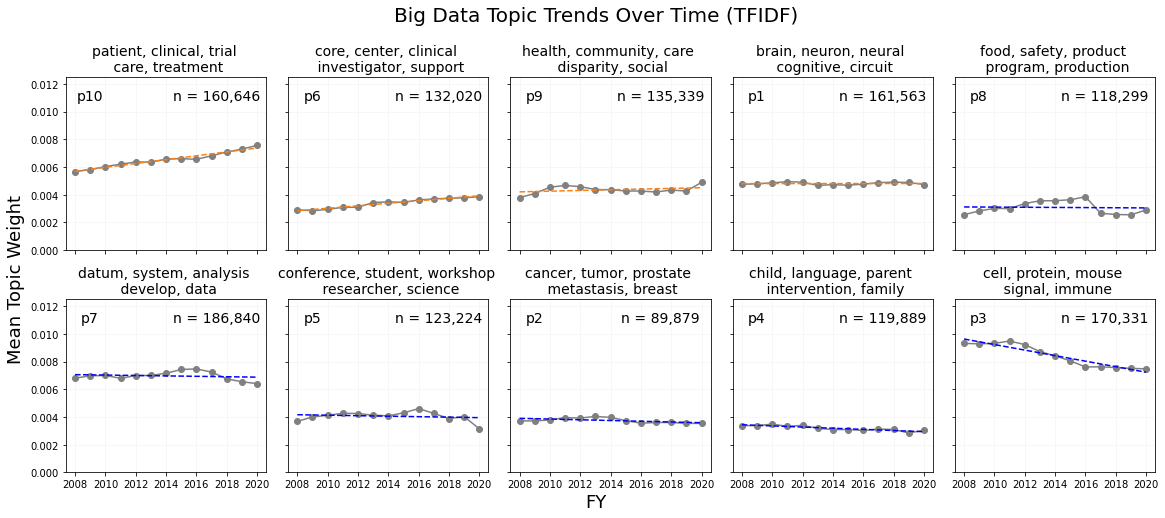

In [140]:
# set up grid
fig, ax = plt.subplots(2, 5, sharex = True, sharey = True, figsize=(16,7))  # 10: 16,7;  20: 16,14;  30: 16,18
plt.ylim(bottom = 0.00, top = 0.0125)   #10: 0.00 - 0.0125;  20: 0.00 - 0.008;   30: 0.00 - 0.006
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_filt.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_filt["FY"].values, topic_wts_filt[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    if(count in [0]): # upward trend in 2020, 20: [0,1,4,9,12]
        line_color = 'gray'
    else: # downward trend in 2020
        line_color = 'gray'
    
    ax[i,j].errorbar(topic_wts_filt["FY"], topic_wts_filt[col], 
            yerr = np.array(topic_wts_se_filt[col]), fmt = '-o', color = line_color, zorder = 10) 
    
    ax[i,j].plot(topic_wts_filt["FY"], \
        (topic_wts_filt["FY"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx], fontsize = 14)
    
    # add topic number to each plot
    ax[i,j].text(0.12, 0.89, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.75, 0.89, "n = " + f"{n_by_topic[col_idx]:,}", horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Big Data Topic Trends Over Time (TFIDF)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.84)  # 10: 0.84, 20: 0.91, 30: 0.92

plt.savefig("./figures/TFIDF/bigdata_10topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.savefig("./figures/TFIDF/bigdata_10topic_trends.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

#### Dominant Topic Funding Calculation

In [11]:
doc_topic[0:10,:]

array([[0.00845296, 0.07049068, 0.        , 0.00658714, 0.        ],
       [0.01185582, 0.09319521, 0.00224731, 0.00562218, 0.        ],
       [0.03102435, 0.04803091, 0.01832113, 0.00285873, 0.00203843],
       [0.03852626, 0.02155132, 0.00809647, 0.        , 0.        ],
       [0.03352749, 0.03444711, 0.01458324, 0.        , 0.        ],
       [0.        , 0.04863175, 0.00178537, 0.        , 0.06031254],
       [0.03941106, 0.04063709, 0.04518765, 0.01690742, 0.        ],
       [0.        , 0.05646649, 0.03004146, 0.        , 0.        ],
       [0.0135932 , 0.04895115, 0.00114625, 0.00498404, 0.00814956],
       [0.        , 0.06310473, 0.        , 0.00581142, 0.        ]])

In [12]:
type(doc_topic)

numpy.ndarray

In [13]:
dom_top_df = df.copy()

In [14]:
dom_top_df['dom_top'] = np.argmax(doc_topic, axis=1)

In [15]:
dom_top_df['dom_top'][0:20]

0     1
1     1
2     1
3     0
4     1
5     4
6     2
7     1
8     1
9     1
10    1
11    1
12    4
13    1
14    1
15    0
16    0
17    2
18    0
19    3
Name: dom_top, dtype: int64

In [16]:
dom_top_df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens,dom_top
0,90045,Study of Emerging Networks in Outbreak Respons...,Arts; Communicable Diseases; Communication; Co...,STUDY OF EMERGING NETWORKS IN OUTBREAK RESPONSE,NSF,NSF,NaN,0826995,9/15/2008,8/31/2012,"ANSELL, CHRISTOPHER","KELLER, ANN; REINGOLD, ARTHUR",09,124726725,UNIVERSITY OF CALIFORNIA BERKELEY,BERKELEY,CA,94704-5940,UNITED STATES,NaN,NaN,47.075,2008,726706.0,NaN,1,1,726706.0,1,study emerging networks outbreak responseprinc...,1
1,90243,One of the products of human development and p...,Affect; Agriculture; anthropogenesis; Award; b...,HSD: COLLABORATIVE RESEARCH: HUMAN-RELATED FAC...,NSF,NSF,NaN,0826779,10/1/2008,3/31/2012,"DASZAK, PETER","KILPATRICK, A MARM",08,077090066,ECOHEALTH ALLIANCE INC,NEW YORK,NY,10001-2320,UNITED STATES,NaN,NaN,47.075,2008,468673.0,NaN,2,2,700001.0,2,product human development population growth gl...,1
2,90573,Intellectual merit:The proposed project seeks ...,base; Basic Science; Biological; Biology; Bird...,COMBINING ECOLOGICAL AND MOLECULAR MODELS TO U...,NSF,NSF,NaN,0827416,9/1/2008,8/31/2011,"KOELLE, KATHARINA",NaN,04,044387793,DUKE UNIVERSITY,DURHAM,NC,27705-4010,UNITED STATES,NaN,NaN,47.074,2008,610071.0,NaN,1,1,610071.0,1,intellectual_merit propose project seek develo...,1
3,91397,West Nile virus re-emerges annually in urban s...,Birds; Chicago; Culicidae; Disease; Environmen...,WEST NILE VIRUS: ECO-EPIDEMIOLOGY OF DISEASE E...,NSF,NSF,NaN,0840403,9/1/2008,8/31/2012,"GOLDBERG, TONY L.","BRAWN, JEFFREY; RUIZ, MARILYN; KITRON, URIEL; ...",02,003255648,UNIVERSITY OF WISCONSIN SYSTEM,MADISON,WI,53715-1218,UNITED STATES,NaN,NaN,47.074,2008,1964529.0,NaN,1,1,1964529.0,1,west_nile virus emerge annually urban setting ...,0
4,93669,About five percent of the world's population d...,Affect; Disabled Persons; Disease; Emerging Co...,RESEARCH STARTER: POPULATION DYNAMICS AND EVOL...,NSF,NSF,NaN,0804039,8/1/2008,7/31/2010,"DENNEHY, JOHN J",NaN,09,064932676,RESEARCH FOUNDATION OF THE CITY UNIVERSITY OF ...,FLUSHING,NY,11367-1575,UNITED STATES,NaN,NaN,47.074,2008,67848.0,NaN,1,1,67848.0,1,percent world population die major influenza p...,1


In [18]:
dollars_by_top_yr = dom_top_df.groupby(['dom_top', 'FY']).agg(COST = ('FY_TOTAL_COST_SUM', 'sum'),
                                        NUM_PROJECTS = ('PROJECT_ID', 'count'))
dollars_by_top_yr

COST  NUM_PROJECTS
dom_top FY                             
0       2008   43115652.0           150
        2009   62764030.0           178
        2010   56867424.0           160
        2011   65145280.0           164
        2012   54054553.0           140
...                   ...           ...
4       2016   80554459.0            55
        2017   60862786.0            54
        2018   60232809.0            54
        2019   62093999.0            52
        2020  485419549.0            64

[65 rows x 2 columns]

In [27]:
dollars_by_top_yr.index.get_level_values(0)

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
            3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', name='dom_top')

In [39]:
dollars_by_top_yr.loc[0,'2008']

COST            43115652.0
NUM_PROJECTS         150.0
Name: (0, 2008), dtype: float64

In [61]:
year = dollars_by_top_yr.loc[0]['COST'].index.values.astype('int')
year

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

In [77]:
dollars_by_top_yr.loc[1]['COST'].values

array([2.49584900e+07, 4.84257350e+07, 4.43161280e+07, 8.42726020e+07,
       2.70007410e+07, 1.94718570e+07, 1.44426010e+07, 2.19935570e+07,
       2.18596360e+07, 2.25130660e+07, 2.91272290e+07, 2.87742200e+07,
       1.71029352e+09])

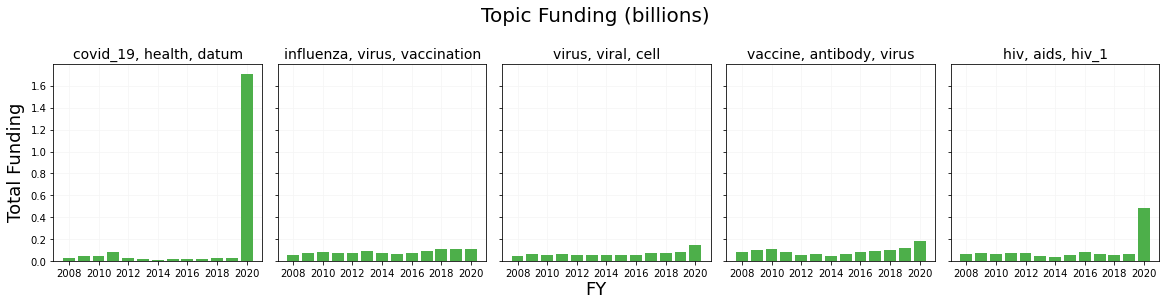

In [88]:
# set up grid
fig, ax = plt.subplots(1, 5, sharex = True, sharey = True, figsize=(16,4))
#plt.ylim(bottom = 0, top = 200) 
#plt.yscale('log')
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count, topic in enumerate([1,2,0,3,4]):
        
    # map count to i,j in grid
    #i = count // 5
    j = count % 5
    
    year = dollars_by_top_yr.loc[topic]['COST'].index.values.astype('int')
    cost = dollars_by_top_yr.loc[topic]['COST'].values/1000000000
    
    ax[j].bar(year, cost, color = cb_pal['green']) 
    ax[j].grid(color = "whitesmoke")   
    ax[j].set_title(new_leg[topic], fontsize = 14)
    ax[j].set_axisbelow(True)
    
    # add topic number to each plot
    #ax[j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    #ax[j].text(0.75, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    
fig.suptitle('Topic Funding (billions)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Total Funding', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.78)

#plt.savefig("./figures/pan_05topic_trends_alt.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("./figures/pan_05topic_trends_alt.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

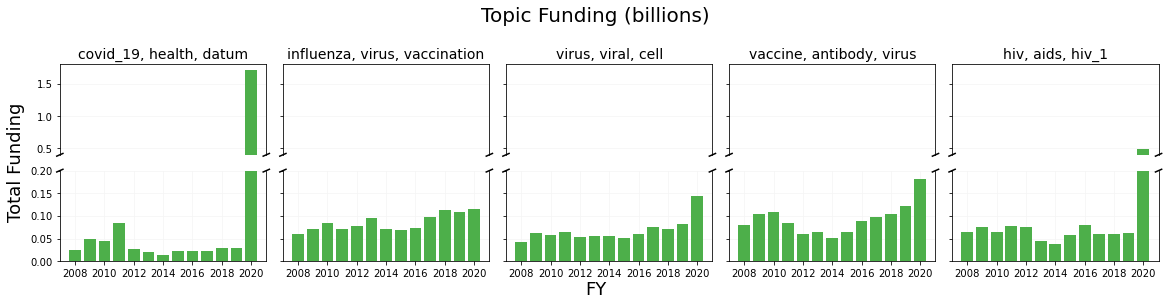

In [112]:
# set up grid
fig, ax = plt.subplots(2, 5, sharex = False, sharey = 'row', figsize=(16,4))
#plt.ylim(bottom = 0, top = 200) 
#plt.yscale('log')
plt.xticks(np.arange(2008,2021,2))

# create plot in each grid square
for count, topic in enumerate([1,2,0,3,4]):
        
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    # plot data
    year = dollars_by_top_yr.loc[topic]['COST'].index.values.astype('int')
    cost = dollars_by_top_yr.loc[topic]['COST'].values/1000000000
    
    ax[i+1,j].bar(year, cost, color = cb_pal['green']) 
    ax[i+1,j].grid(color = "whitesmoke")   
    ax[i+1,j].set_axisbelow(True)
    
    ax[i,j].bar(year, cost, color = cb_pal['green']) 
    ax[i,j].grid(color = "whitesmoke")   
    ax[i,j].set_title(new_leg[topic], fontsize = 14)
    ax[i,j].set_axisbelow(True)
    
    # broken axis
    ax[i,j].spines['bottom'].set_visible(False)
    ax[i,j].set_xticks([])
    ax[i+1,j].set_xticks(np.arange(2008,2021,2))
    ax[i+1,j].spines['top'].set_visible(False)
    ax[i+1,j].set_ylim([0,0.2])
    ax[i,j].set_ylim([0.4,1.8])
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax[i,j].transAxes, color='k', clip_on=False)
    ax[i,j].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax[i,j].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax[i+1,j].transAxes)  # switch to the bottom axes
    ax[i+1,j].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax[i+1,j].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    
    # add topic number to each plot
    #ax[j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    #ax[j].text(0.75, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
    #             transform=ax[j].transAxes, fontsize = 14)
    
    
fig.suptitle('Topic Funding (billions)', fontsize = 20)
fig.text(0.5, -0.003, 'FY', ha='center', va='center', fontsize = 18)
fig.text(-0.003, 0.44, 'Total Funding', ha='center', va='center', rotation='vertical', fontsize = 18) #0.45
fig.tight_layout()
fig.subplots_adjust(top=0.78)

plt.savefig("./figures/OECD/pan_05topic_funding.png", dpi = 800, bbox_inches = "tight")
plt.savefig("./figures/OECD/pan_05topic_funding.pdf", dpi = 800, bbox_inches = "tight")
plt.show()